In [ ]:
#installing some important libraries
!pip install numpy pandas geopandas scikit-learn matplotlib pykrige

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from pykrige.ok import OrdinaryKriging  

In [ ]:

# Loading CSV data for weather station measurements and metadata
weather_data = pd.read_csv('weather_station_data_202406202154.csv')
station_data = pd.read_csv('weather_stations_202406211148.csv')

In [ ]:
# Loading geographic shapefiles for lakes and rivers
aosta_lakes = gpd.read_file('idrografia_laghi.shp')
aosta_rivers = gpd.read_file('idrografia_lineare.shp')

In [ ]:
# Displaying data to confirm it loaded correctly
print(weather_data.head())
print(station_data.head())
print(aosta_lakes.head())
print(aosta_rivers.head())

  station_id  temperature                timestamp
0        NaN         16.0  2024-05-04 18:41:22.000
1        NaN         16.1  2024-05-05 19:26:04.000
2        NaN         12.2  2024-05-06 06:35:18.000
3        NaN         11.0  2024-05-07 09:21:12.000
4        NaN         10.9  2024-05-07 10:06:30.000
                 id                                     name  altitude  \
0     castelceriolo         Alessandria, fraz. Castelceriolo       100   
1   orsieres-prayon                    Orsières, Prayon (CH)      1509   
2           alpette                             Alpette (TO)       980   
3  alluvioni-cambio  Alluvioni Piovera, fraz. Baracconi (AL)        79   
4   alice-bel-colle                     Alice Bel Colle (AL)       418   

   latitude  longitude  
0   8.70080   44.90400  
1   7.10440   45.94800  
2   7.58150   45.40710  
3   8.77137   44.98922  
4   8.45050   44.72560  
  codcom cod_lago                     nome    tiplago immlago  quota  \
0    007     None  LACS DES

In [ ]:
# Merging Weather Data with Station Metadata
# Rename 'id' to 'station_id' in station_data for merging
station_data.rename(columns={'id': 'station_id'}, inplace=True)

In [ ]:
# Merging weather data with station metadata using station_id
merged_data = pd.merge(weather_data, station_data, on='station_id', how='right')

In [ ]:
# Converting merged data to GeoDataFrame for spatial analysis
station_gdf = gpd.GeoDataFrame(
    merged_data,
    geometry=gpd.points_from_xy(merged_data.longitude, merged_data.latitude),
    crs="EPSG:4326"
)


In [ ]:
# Checking the merged data
print(station_gdf.head())

      station_id  temperature                timestamp  \
0  castelceriolo         17.2  2024-05-01 00:00:05.174   
1  castelceriolo         17.1  2024-05-01 00:05:04.485   
2  castelceriolo         16.9  2024-05-01 00:10:04.772   
3  castelceriolo         16.6  2024-05-01 00:15:05.279   
4  castelceriolo         16.4  2024-05-01 00:20:04.545   

                               name  altitude  latitude  longitude  \
0  Alessandria, fraz. Castelceriolo       100    8.7008     44.904   
1  Alessandria, fraz. Castelceriolo       100    8.7008     44.904   
2  Alessandria, fraz. Castelceriolo       100    8.7008     44.904   
3  Alessandria, fraz. Castelceriolo       100    8.7008     44.904   
4  Alessandria, fraz. Castelceriolo       100    8.7008     44.904   

                geometry  
0  POINT (44.904 8.7008)  
1  POINT (44.904 8.7008)  
2  POINT (44.904 8.7008)  
3  POINT (44.904 8.7008)  
4  POINT (44.904 8.7008)  


In [ ]:
# Converting CRS and Spatial Operations
station_gdf = station_gdf.to_crs("EPSG:32632")
aosta_lakes = aosta_lakes.to_crs("EPSG:32632")
aosta_rivers = aosta_rivers.to_crs("EPSG:32632")

In [ ]:
# Dropping 'index_right' if it exists to prevent conflicts during join
if 'index_right' in station_gdf.columns:
    station_gdf.drop(columns=['index_right'], inplace=True)
if 'index_right' in aosta_lakes.columns:
    aosta_lakes.drop(columns=['index_right'], inplace=True)

In [ ]:
# Finding nearest lake for each station
nearest_lakes = gpd.sjoin_nearest(station_gdf, aosta_lakes, how='left', distance_col='distance_to_lake')

In [ ]:
# Dropping 'index_right' column if it exists before next join
if 'index_right' in nearest_lakes.columns:
    nearest_lakes.drop(columns=['index_right'], inplace=True)

In [ ]:
# Finding nearest river for each station
nearest_rivers = gpd.sjoin_nearest(nearest_lakes, aosta_rivers, how='left', distance_col='distance_to_river')

In [ ]:
# Updating the GeoDataFrame
station_gdf = nearest_rivers


In [16]:
# Verify the columns after spatial joins
print(station_gdf.columns)

Index(['station_id', 'temperature', 'timestamp', 'name', 'altitude',
       'latitude', 'longitude', 'geometry', 'codcom', 'cod_lago', 'nome_left',
       'tiplago', 'immlago', 'quota', 'orilago', 'st_area_sh',
       'st_length__left', 'distance_to_lake', 'index_right', 'ordine', 'tipol',
       'dir_flusso', 'cod_sibapo', 'llpp', 'codice', 'cod_siba_1', 'z_ini',
       'z_fin', 'nome_right', 'num_archi', 'lung_tot', 'tratto', 'pendenz_m',
       'denbacpri', 'codbacpri', 'denbacsec', 'codbacsec', 'principale',
       'lung_geom', 'st_length__right', 'distance_to_river'],
      dtype='object')


In [ ]:
# Convert timestamp to datetime format if not already done
station_gdf['timestamp'] = pd.to_datetime(station_gdf['timestamp'])

In [18]:
# Add temporal features
station_gdf['hour'] = station_gdf['timestamp'].dt.hour
station_gdf['day_of_week'] = station_gdf['timestamp'].dt.dayofweek
station_gdf['day_of_year'] = station_gdf['timestamp'].dt.dayofyear
station_gdf['month'] = station_gdf['timestamp'].dt.month

In [ ]:
print(station_gdf.head())

      station_id  temperature               timestamp  \
0  castelceriolo         17.2 2024-05-01 00:00:05.174   
1  castelceriolo         17.1 2024-05-01 00:05:04.485   
2  castelceriolo         16.9 2024-05-01 00:10:04.772   
3  castelceriolo         16.6 2024-05-01 00:15:05.279   
4  castelceriolo         16.4 2024-05-01 00:20:04.545   

                               name  altitude  latitude  longitude  \
0  Alessandria, fraz. Castelceriolo       100    8.7008     44.904   
1  Alessandria, fraz. Castelceriolo       100    8.7008     44.904   
2  Alessandria, fraz. Castelceriolo       100    8.7008     44.904   
3  Alessandria, fraz. Castelceriolo       100    8.7008     44.904   
4  Alessandria, fraz. Castelceriolo       100    8.7008     44.904   

                          geometry codcom cod_lago  ...       denbacsec  \
0  POINT (4722996.733 1184669.834)    042     None  ...  Torrent Pacola   
1  POINT (4722996.733 1184669.834)    042     None  ...  Torrent Pacola   
2  POINT (4

In [ ]:
station_gdf = station_gdf.dropna(subset=['temperature'])

In [ ]:
features = ['hour', 'day_of_week', 'latitude', 'longitude', 'distance_to_lake', 'distance_to_river']
X = station_gdf[features]
y = station_gdf['temperature']

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [ ]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [ ]:
y_pred = rf_model.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 6.806327878177703


In [29]:
# Step 12: Kriging (Optional Step for Spatial Interpolation)
# Extract spatial coordinates and temperature data for kriging
coordinates = list(zip(station_gdf.geometry.x, station_gdf.geometry.y))
temperature = station_gdf['temperature'].values

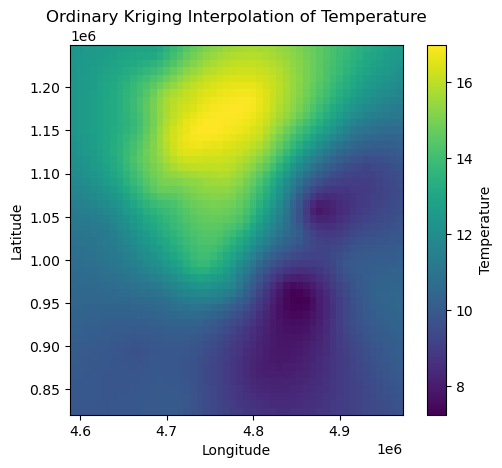

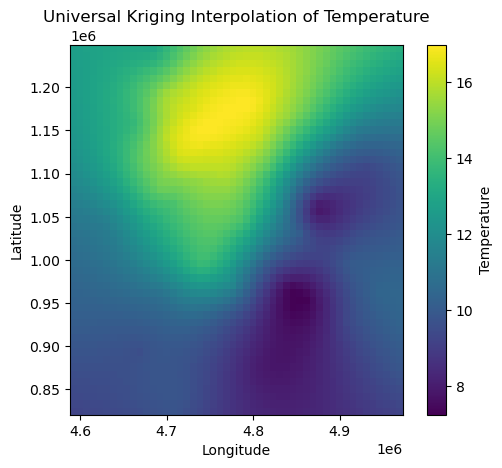

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging
from pykrige.uk import UniversalKriging

temp_station_gdf = station_gdf.sample(n=500, random_state=42)  # Limiting to 500 samples for efficient processing

# Create an Ordinary Kriging model
OK = OrdinaryKriging(
    temp_station_gdf.geometry.x,
    temp_station_gdf.geometry.y,
    temp_station_gdf['temperature'],
    variogram_model='linear'
)

gridx = np.linspace(temp_station_gdf.geometry.x.min(), temp_station_gdf.geometry.x.max(), 50)  # Reduce grid size for memory efficiency
gridy = np.linspace(temp_station_gdf.geometry.y.min(), temp_station_gdf.geometry.y.max(), 50)

z_ok, ss_ok = OK.execute('grid', gridx, gridy)

# Plotting Ordinary Kriging results
plt.imshow(z_ok, extent=(gridx.min(), gridx.max(), gridy.min(), gridy.max()), origin='lower')
plt.title('Ordinary Kriging Interpolation of Temperature')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Temperature')
plt.show()

UK = UniversalKriging(
    temp_station_gdf.geometry.x,
    temp_station_gdf.geometry.y,
    temp_station_gdf['temperature'],
    variogram_model='linear',
    drift_terms=['regional_linear']  # Adding a linear drift term
)

z_uk, ss_uk = UK.execute('grid', gridx, gridy)

plt.imshow(z_uk, extent=(gridx.min(), gridx.max(), gridy.min(), gridy.max()), origin='lower')
plt.title('Universal Kriging Interpolation of Temperature')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Temperature')
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = ['hour', 'day_of_week', 'latitude', 'longitude', 'distance_to_lake', 'distance_to_river']
X = station_gdf[features].values
y = station_gdf['temperature'].values

scaler_X = StandardScaler()
X = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

num_nodes = X.shape[0]
adjacency_matrix = np.dot(X, X.T)
np.fill_diagonal(adjacency_matrix, 1.0)  # Add self-loops

adjacency_matrix /= adjacency_matrix.sum(axis=1, keepdims=True)

X_train, X_test, y_train, y_test, adj_train, adj_test = train_test_split(X, y, adjacency_matrix, test_size=0.2, random_state=42)

class SimpleGCNLayer(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(SimpleGCNLayer, self).__init__()
        self.output_dim = output_dim

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(input_shape[-1], self.output_dim),
                                      initializer='glorot_uniform',
                                      trainable=True)

    def call(self, inputs, adjacency_matrix):
        x = tf.matmul(adjacency_matrix, inputs)  # Aggregate neighbor information
        x = tf.matmul(x, self.kernel)  # Linear transformation
        return tf.nn.relu(x)

input_features = Input(shape=(X.shape[1],))
adjacency_input = Input(shape=(num_nodes,))

gcn_layer_1 = SimpleGCNLayer(output_dim=16)(input_features, adjacency_input)
gcn_layer_1 = BatchNormalization()(gcn_layer_1)
gcn_layer_1 = Dropout(0.3)(gcn_layer_1)




Epoch 1/100


c:\Users\niran\miniconda3\envs\era5_project\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_26', 'keras_tensor_27']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.9213
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.9356
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.5305
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.3795
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 1.0198
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.1352
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.7941
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3322
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 1.0274
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.9339
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6382
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.5710
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7054
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.8154
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.9826
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━━

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, Add, GlobalAveragePooling1D
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

features = ['hour', 'day_of_week', 'latitude', 'longitude', 'distance_to_lake', 'distance_to_river']
X = station_gdf[features].values
y = station_gdf['temperature'].values

X = (X - X.mean(axis=0)) / X.std(axis=0)
y = (y - y.mean()) / y.std()

timesteps = 10
input_dim = X.shape[1]

X_seq, y_seq = [], []
for i in range(len(X) - timesteps):
    X_seq.append(X[i:i + timesteps])
    y_seq.append(y[i + timesteps])  # Use the value after the sequence as target

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

def transformer_block(inputs, num_heads, ff_dim, rate=0.1):
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(rate)(attention_output)
    attention_output = Add()([inputs, attention_output])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    ff_output = Dense(ff_dim, activation='relu')(attention_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(rate)(ff_output)
    output = Add()([attention_output, ff_output])
    output = LayerNormalization(epsilon=1e-6)(output)

    return output

# Define Transformer model
inputs = Input(shape=(timesteps, input_dim))
transformer_output = transformer_block(inputs, num_heads=4, ff_dim=128, rate=0.1)
transformer_output = transformer_block(transformer_output, num_heads=4, ff_dim=128, rate=0.1)

# Global average pooling to reduce the sequence dimension
transformer_output = GlobalAveragePooling1D()(transformer_output)

# Output layer
output = Dense(1)(transformer_output)

model = Model(inputs=inputs, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1, validation_split=0.2)

# Predict and evaluate
predictions = model.predict(X_test)

# Flatten predictions and targets for evaluation
predictions_flat = predictions.flatten()
y_test_flat = y_test.flatten()

# Calculate evaluation metrics
mse = mean_squared_error(y_test_flat, predictions_flat)
mae = mean_absolute_error(y_test_flat, predictions_flat)
r2 = r2_score(y_test_flat, predictions_flat)

# Print metrics
print(f"Transformer Model - MSE: {mse}, MAE: {mae}, R²: {r2}")


Epoch 1/5
48806/48806 ━━━━━━━━━━━━━━━━━━━━ 299s 6ms/step - loss: 0.5155 - val_loss: 0.4265
Epoch 2/5
48806/48806 ━━━━━━━━━━━━━━━━━━━━ 289s 6ms/step - loss: 0.3983 - val_loss: 0.4188
Epoch 3/5
48806/48806 ━━━━━━━━━━━━━━━━━━━━ 287s 6ms/step - loss: 0.3523 - val_loss: 0.4227
Epoch 4/5
48806/48806 ━━━━━━━━━━━━━━━━━━━━ 294s 6ms/step - loss: 0.3314 - val_loss: 0.4472
Epoch 5/5
48806/48806 ━━━━━━━━━━━━━━━━━━━━ 289s 6ms/step - loss: 0.3189 - val_loss: 0.4177
15252/15252 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step
Transformer Model - MSE: 0.4194637602839067, MAE: 0.49265661145844775, R²: 0.5809703703953922


Epoch 1/10
244027/244027 ━━━━━━━━━━━━━━━━━━━━ 923s 4ms/step - loss: 32.7479
Epoch 2/10
244027/244027 ━━━━━━━━━━━━━━━━━━━━ 920s 4ms/step - loss: 30.4663
Epoch 3/10
244027/244027 ━━━━━━━━━━━━━━━━━━━━ 935s 4ms/step - loss: 30.2405
Epoch 4/10
244027/244027 ━━━━━━━━━━━━━━━━━━━━ 791s 3ms/step - loss: 30.3971
Epoch 5/10
244027/244027 ━━━━━━━━━━━━━━━━━━━━ 770s 3ms/step - loss: 30.4173
Epoch 6/10
244027/244027 ━━━━━━━━━━━━━━━━━━━━ 765s 3ms/step - loss: 30.4668
Epoch 7/10
244027/244027 ━━━━━━━━━━━━━━━━━━━━ 654s 3ms/step - loss: 30.4402
Epoch 8/10
244027/244027 ━━━━━━━━━━━━━━━━━━━━ 714s 3ms/step - loss: 30.3744
Epoch 9/10
244027/244027 ━━━━━━━━━━━━━━━━━━━━ 657s 3ms/step - loss: 30.3278
Epoch 10/10
244027/244027 ━━━━━━━━━━━━━━━━━━━━ 669s 3ms/step - loss: 30.4923
7626/7626 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step

Epoch 1/50
244027/244027 ━━━━━━━━━━━━━━━━━━━━ 654s 3ms/step - loss: 33.7392
Epoch 2/50
244027/244027 ━━━━━━━━━━━━━━━━━━━━ 629s 3ms/step - loss: 31.2004
Epoch 3/50
244027/244027 ━━━━━━━━━━━━━━━━━

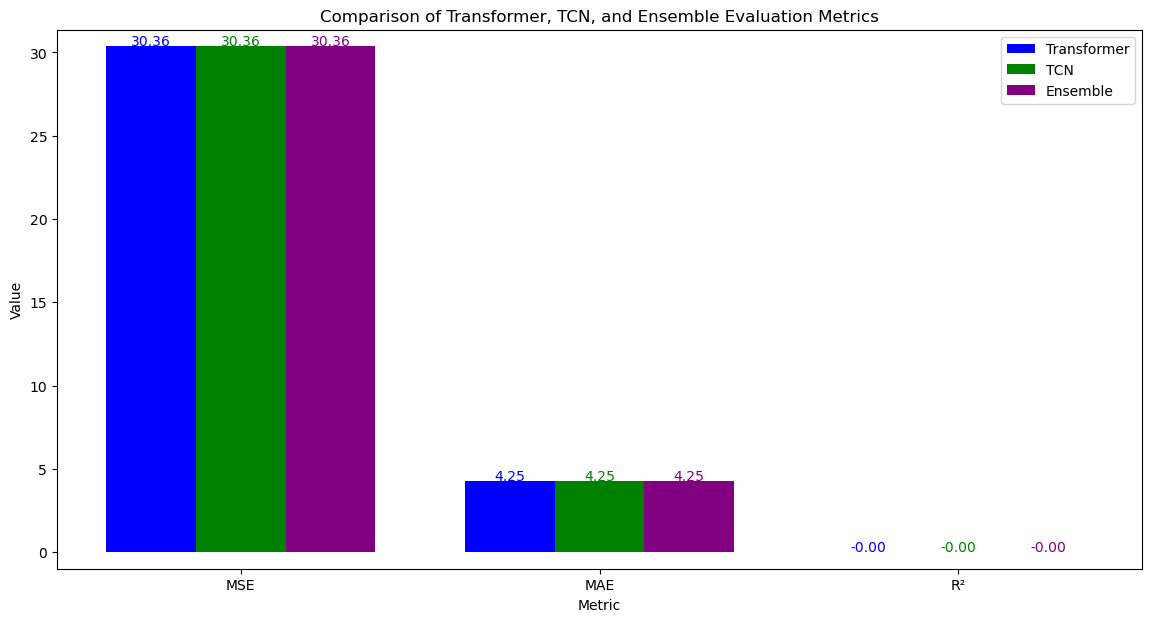

c:\Users\niran\miniconda3\envs\era5_project\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


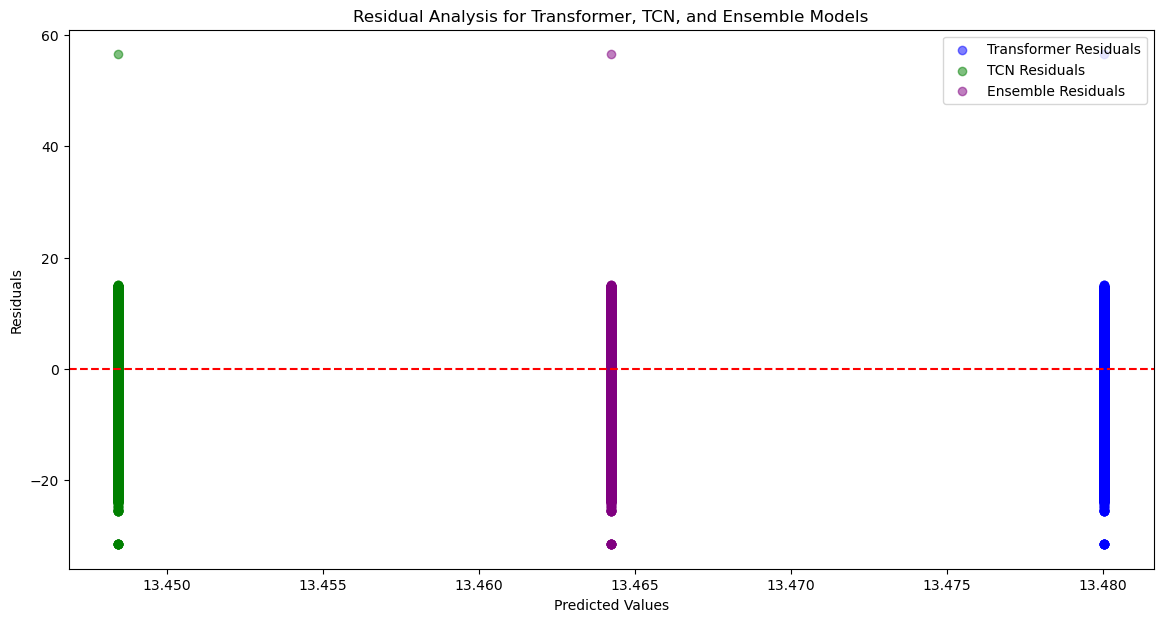

In [ ]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, Add, Conv1D, BatchNormalization, Activation
from tensorflow.keras.models import Model
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def transformer_block(inputs, num_heads, ff_dim, rate=0.1):
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=inputs.shape[-1])(inputs, inputs)
    attention_output = Dropout(rate)(attention_output)
    attention_output = Add()([inputs, attention_output])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    ff_output = Dense(ff_dim, activation='relu')(attention_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(rate)(ff_output)
    output = Add()([attention_output, ff_output])
    output = LayerNormalization(epsilon=1e-6)(output)

    return output

class TCNBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, dilation_rate, dropout_rate=0.2):
        super(TCNBlock, self).__init__()
        self.conv1 = Conv1D(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='causal')
        self.batch_norm1 = BatchNormalization()
        self.conv2 = Conv1D(filters=filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding='causal')
        self.batch_norm2 = BatchNormalization()
        self.dropout = Dropout(dropout_rate)

    def call(self, inputs, **kwargs):
        x = self.conv1(inputs)
        x = self.batch_norm1(x)
        x = Activation('relu')(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = Activation('relu')(x)
        x = self.dropout(x)
        return x

features = ['hour', 'day_of_week', 'latitude', 'longitude', 'distance_to_lake', 'distance_to_river']
X = station_gdf[features].values.astype(np.float32)  # Convert to numpy array
y = station_gdf['temperature'].values.astype(np.float32)  # Convert to numpy array

timesteps = 10  # Number of timesteps for LSTM/TCN
batch_size = X.shape[0] // timesteps
X_reshaped = X[:batch_size * timesteps].reshape(batch_size, timesteps, -1)
y_reshaped = y[:batch_size * timesteps].reshape(batch_size, timesteps, 1)

inputs = Input(shape=(timesteps, X_reshaped.shape[-1]))
transformer_output = transformer_block(inputs, num_heads=4, ff_dim=128, rate=0.1)
transformer_output = transformer_block(transformer_output, num_heads=4, ff_dim=128, rate=0.1)

output_transformer = Dense(1)(transformer_output)

transformer_model = Model(inputs=inputs, outputs=output_transformer)
transformer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')

transformer_model.fit(X_reshaped, y_reshaped, epochs=10, batch_size=1, verbose=1)

predictions_transformer = transformer_model.predict(X_reshaped)

inputs_tcn = Input(shape=(timesteps, X_reshaped.shape[-1]))
tcn_block = TCNBlock(filters=64, kernel_size=3, dilation_rate=1)(inputs_tcn)
tcn_block = TCNBlock(filters=64, kernel_size=3, dilation_rate=2)(tcn_block)

output_tcn = Dense(1)(tcn_block)

tcn_model = Model(inputs=inputs_tcn, outputs=output_tcn)
tcn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='mse')

tcn_model.fit(X_reshaped, y_reshaped, epochs=50, batch_size=1, verbose=1)

predictions_tcn = tcn_model.predict(X_reshaped)

predictions_transformer_flat = predictions_transformer.flatten()
predictions_tcn_flat = predictions_tcn.flatten()
y_flat = y_reshaped.flatten()

mse_transformer = mean_squared_error(y_flat, predictions_transformer_flat)
mae_transformer = mean_absolute_error(y_flat, predictions_transformer_flat)
r2_transformer = r2_score(y_flat, predictions_transformer_flat)

mse_tcn = mean_squared_error(y_flat, predictions_tcn_flat)
mae_tcn = mean_absolute_error(y_flat, predictions_tcn_flat)
r2_tcn = r2_score(y_flat, predictions_tcn_flat)

ensemble_predictions = (predictions_transformer_flat + predictions_tcn_flat) / 2
mse_ensemble = mean_squared_error(y_flat, ensemble_predictions)
mae_ensemble = mean_absolute_error(y_flat, ensemble_predictions)
r2_ensemble = r2_score(y_flat, ensemble_predictions)

print(f"Transformer Model - MSE: {mse_transformer}, MAE: {mae_transformer}, R²: {r2_transformer}")
print(f"TCN Model - MSE: {mse_tcn}, MAE: {mae_tcn}, R²: {r2_tcn}")
print(f"Ensemble Model - MSE: {mse_ensemble}, MAE: {mae_ensemble}, R²: {r2_ensemble}")

metrics_transformer = {'MSE': mse_transformer, 'MAE': mae_transformer, 'R²': r2_transformer}
metrics_tcn = {'MSE': mse_tcn, 'MAE': mae_tcn, 'R²': r2_tcn}
metrics_ensemble = {'MSE': mse_ensemble, 'MAE': mae_ensemble, 'R²': r2_ensemble}

names = list(metrics_transformer.keys())
values_transformer = list(metrics_transformer.values())
values_tcn = list(metrics_tcn.values())
values_ensemble = list(metrics_ensemble.values())

x = np.arange(len(names))
width = 0.25

plt.figure(figsize=(14, 7))
plt.bar(x - width, values_transformer, width, label='Transformer', color='blue')
plt.bar(x, values_tcn, width, label='TCN', color='green')
plt.bar(x + width, values_ensemble, width, label='Ensemble', color='purple')
plt.title('Comparison of Transformer, TCN, and Ensemble Evaluation Metrics')
plt.ylabel('Value')
plt.xlabel('Metric')
plt.xticks(x, names)
plt.ylim(bottom=min(values_transformer + values_tcn + values_ensemble) - 1, top=max(values_transformer + values_tcn + values_ensemble) + 1)
plt.legend()
for i, (val_t, val_c, val_e) in enumerate(zip(values_transformer, values_tcn, values_ensemble)):
    plt.text(i - width, val_t + 0.05, f'{val_t:.2f}', ha='center', color='blue')
    plt.text(i, val_c + 0.05, f'{val_c:.2f}', ha='center', color='green')
    plt.text(i + width, val_e + 0.05, f'{val_e:.2f}', ha='center', color='purple')
plt.show()

residuals_transformer = y_flat - predictions_transformer_flat
residuals_tcn = y_flat - predictions_tcn_flat
residuals_ensemble = y_flat - ensemble_predictions

plt.figure(figsize=(14, 7))
plt.scatter(predictions_transformer_flat, residuals_transformer, color='blue', alpha=0.5, label='Transformer Residuals')
plt.scatter(predictions_tcn_flat, residuals_tcn, color='green', alpha=0.5, label='TCN Residuals')
plt.scatter(ensemble_predictions, residuals_ensemble, color='purple', alpha=0.5, label='Ensemble Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Analysis for Transformer, TCN, and Ensemble Models')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()


In [49]:
import xgboost as xgb

# Initialize XGBoost Regressor
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

# Train the XGBoost model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the XGBoost model's performance
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Evaluation Metrics:")
print(f"MSE: {mse_xgb}")
print(f"MAE: {mae_xgb}")
print(f"R² Score: {r2_xgb}")


XGBoost Evaluation Metrics:
MSE: 7.3018446739055864
MAE: 2.126138288134584
R² Score: 0.759970269419414


Epoch 1/10
122014/122014 ━━━━━━━━━━━━━━━━━━━━ 290s 2ms/step - loss: 14.1632 - mae: 2.8163 - val_loss: 9.1077 - val_mae: 2.3717
Epoch 2/10
122014/122014 ━━━━━━━━━━━━━━━━━━━━ 328s 3ms/step - loss: 9.0220 - mae: 2.3560 - val_loss: 8.4117 - val_mae: 2.2801
Epoch 3/10
122014/122014 ━━━━━━━━━━━━━━━━━━━━ 331s 3ms/step - loss: 8.3526 - mae: 2.2709 - val_loss: 8.2416 - val_mae: 2.2480
Epoch 4/10
122014/122014 ━━━━━━━━━━━━━━━━━━━━ 331s 3ms/step - loss: 8.0592 - mae: 2.2348 - val_loss: 7.7862 - val_mae: 2.1928
Epoch 5/10
122014/122014 ━━━━━━━━━━━━━━━━━━━━ 333s 3ms/step - loss: 7.9305 - mae: 2.2140 - val_loss: 7.6746 - val_mae: 2.1837
Epoch 6/10
122014/122014 ━━━━━━━━━━━━━━━━━━━━ 336s 3ms/step - loss: 7.8221 - mae: 2.2021 - val_loss: 7.7029 - val_mae: 2.1865
Epoch 7/10
122014/122014 ━━━━━━━━━━━━━━━━━━━━ 336s 3ms/step - loss: 7.7703 - mae: 2.1946 - val_loss: 7.6666 - val_mae: 2.1816
Epoch 8/10
122014/122014 ━━━━━━━━━━━━━━━━━━━━ 337s 3ms/step - loss: 7.7179 - mae: 2.1873 - val_loss: 7.6722 - val_mae

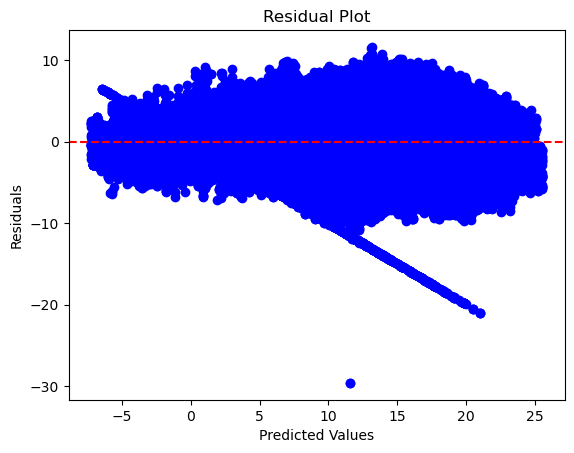

In [53]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Dense, LSTM, Conv3D, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load dataset
features = ['hour', 'day_of_week', 'latitude', 'longitude', 'distance_to_lake', 'distance_to_river']
X = station_gdf[features]
y = station_gdf['temperature']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the feature data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for LSTM
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the LSTM + CNN model
input_layer = Input(shape=(1, X_train_scaled.shape[1]))
lstm_out = LSTM(32, return_sequences=True)(input_layer)

# CNN Layer to capture spatial dependencies
cnn_input = tf.keras.layers.Reshape((1, 1, 32, 1))(lstm_out)  # Adding a channel dimension
conv_out = Conv3D(filters=16, kernel_size=(1, 1, 3), activation='relu')(cnn_input)
flatten_out = Flatten()(conv_out)

# Dense layers for final predictions
dense_out = Dense(32, activation='relu')(flatten_out)
output_layer = Dense(1)(dense_out)

# Compile the model
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Fit the model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(X_train_reshaped, y_train, epochs=10, batch_size=16, validation_data=(X_test_reshaped, y_test),
          callbacks=[early_stopping], verbose=1)

# Predict and evaluate
y_pred = model.predict(X_test_reshaped)

# Evaluation metrics
mse = tf.keras.losses.MeanSquaredError()(y_test, y_pred).numpy()
mae = tf.keras.losses.MeanAbsoluteError()(y_test, y_pred).numpy()
r2 = 1 - (np.sum((y_test - y_pred.flatten())**2) / np.sum((y_test - y_test.mean())**2))

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R^2 Score: {r2}")

# Residual plot
residuals = y_test - y_pred.flatten()
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()
